In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# PDE Setup
Length = 10.
xspan = np.array([0., Length])
H = 0.05
T_a = 200.
T_bc = 400.

# Exact solution (when $H \ne 0$):
$$
-T'' + HT = HT_a
$$

$$T(x) = A \cosh(\sqrt{H}x) + B\sinh(\sqrt{H}x) + T_a$$

BC:
  - $T'(0)=-20$  $\qquad\longrightarrow \quad B=\frac{-20}{\sqrt{H}}$
  - $T(L) = 400$ $\qquad\longrightarrow \quad A=\frac{T_L - T_a - B \sinh(\sqrt{H}L) }{\cosh(\sqrt{H}L)}$


In [3]:
# Exact Solution
# T_true = lambda x:  200 + 20.4681*np.exp(np.sqrt(H)*x) + 79.539*np.exp(-np.sqrt(H)*x)
cB = -20 / np.sqrt(H)
cA = (T_bc-T_a -cB*np.sinh(np.sqrt(H)*Length)) / np.cosh(np.sqrt(H)*Length)
T_true = lambda x:  T_a + cA * np.cosh(np.sqrt(H)*x) + cB * np.sinh(np.sqrt(H)*x)

# PDE Discretization and check steady-state solution

In [4]:
def build_linear_system(xspan, bv, n_cells, H, T_a, bc_high=False, plot_mat=False):

    h = np.diff(xspan)[0]/n_cells
    print('mesh spacing = ',h)
    n_points = n_cells+1
    x = np.linspace(xspan[0], xspan[1], n_points)

    A = np.zeros((n_points,n_points))
    b = np.zeros(n_points)
    # Assemble matrix
    for i in range(1,n_points-1):
        A[i,i] = 2 / h + H * h
        A[i,i-1] = -1 / h
        A[i,i+1] = -1 / h
        b[i] = H * T_a * h
    # Set Boundary conditions to the left
    if not bc_high:
        A[0 , 0] = 1/h
        A[0 , 1] = -1/h
        b[0]     = -bv[0]
    else:
        A[0 , 0] = 1/h + H * h/2
        A[0 , 1] = -1/h
        b[0]     = H * h/2 * T_a - bv[0]
    # Set Boundary conditions to the right 
#     A[-1,-1] = 1
#     b[-1]    = bv[1]
    A = np.delete(A,-1, axis=0)
    b = np.delete(b,-1)
    b[-1] -= A[-1,-1] * bv[1]
    A = np.delete(A,-1, axis=1)

    if plot_mat:
        plt.figure()
        plt.spy(A)
    
    return x, A, b

def solve_linear_system(A,b):
    # Solve
    T = np.linalg.solve(A,b)
    return T

In [5]:
def add_bc(u):
    return np.append(u,T_bc)

mesh spacing =  0.05
mesh spacing =  0.05


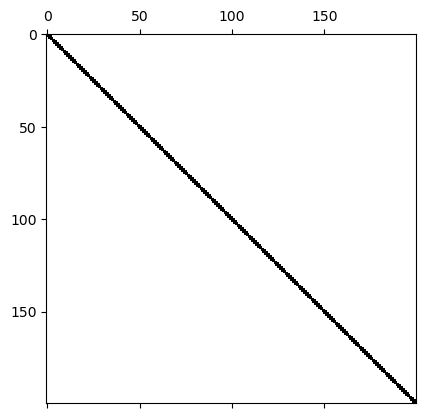

In [6]:
ncells = 200
bv = [-20, T_bc]

x, A_low, b_low = build_linear_system(xspan, bv , ncells,  H, T_a, bc_high=False, plot_mat=True)
x, A, b = build_linear_system(xspan, bv , ncells,  H, T_a, bc_high=True, plot_mat=False)
# print(x)

0.7115624306609902
-0.0009313266502886108
329.6907516151468


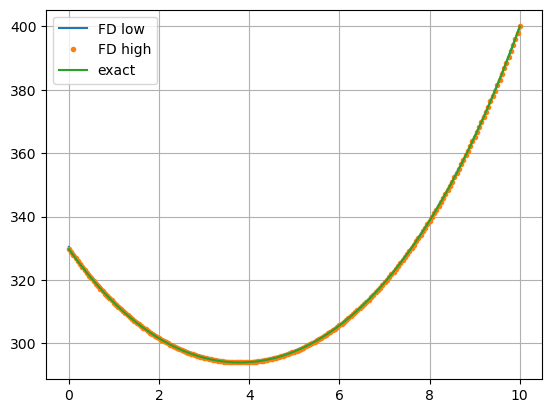

In [7]:
T_low = solve_linear_system(A_low,b_low)
print(T_low[0]-T_true(0))

T = solve_linear_system(A,b)
print(T[0]-T_true(0))

print(T_true(0))

plt.figure()
plt.plot(x, add_bc(T_low), label = 'FD low')
plt.plot(x, add_bc(T), '.',label = 'FD high')
plt.plot(x, T_true(x), label = 'exact')
plt.grid(True)
plt.legend()
plt.show()

In [8]:
.0036515756049766424*4

0.01460630241990657

# Solve time-dependent problem with IVP solvers
For temporal excitation, I have chosen
$$
excite(t) = 1+ 0.5\cos{(\pi t)} \exp{(-t/10)}
$$

(1299,)
(200, 1299)


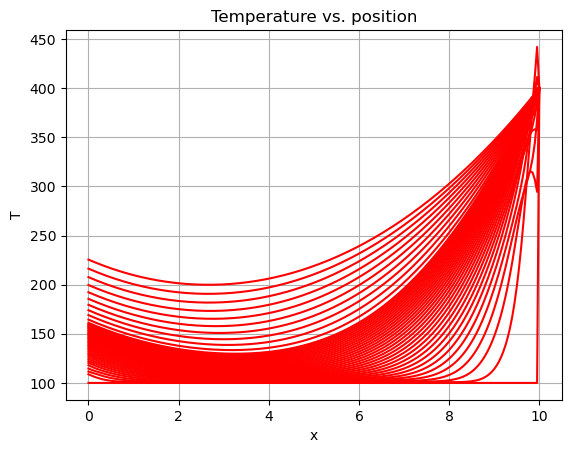

In [9]:
from scipy.integrate import solve_ivp
import time as time

# definition excitation of the heat source 
def excitation(t):
    return ( 1+ 0.5*np.cos(np.pi * t)*np.exp(-t/10) )

def FOM_function(t,u,A,b):
    return -A@u + b * excitation(t)
#     return -A@u + b *  (1-np.exp(-t)) * np.cos(np.pi * t)

# initial flat temperature
Tinit = np.ones(len(b))*T_bc*0+100

# solve the ODE
rtol_=1e-5
atol_=1e-5
Tend = 250.

ntimes1= 1000
t_events1 = np.linspace(0,Tend/3,ntimes1)
ntimes2= 300
t_events2 = np.geomspace(t_events1[-1],Tend,ntimes2)
t_events = np.hstack((t_events1,t_events2[1:]))

FOM = solve_ivp(FOM_function, [0, Tend], Tinit, t_eval=t_events, args=(A,b), \
                rtol=rtol_, atol=atol_, method='Radau')

print(FOM.t.shape)
print(FOM.y.shape)

# plots all snapshots
plt.figure()
for it,t in enumerate(t_events):
    if it%30==0:
        plt.plot(x,add_bc(FOM.y[:,it]),'r')
plt.xlabel('x')
plt.ylabel('T')
plt.title('Temperature vs. position')
plt.grid(True)
plt.show()

# SVD

In [10]:
from scipy.linalg import svd

In [11]:
# data matrix (collected snapshots)
X = np.copy(FOM.y)
print("Rank of data matrix = {0} --> so there will be at most {0} SV's".format(np.linalg.matrix_rank(X)))

Rank of data matrix = 44 --> so there will be at most 44 SV's


Shapes:
	U (200, 200)
	Sigma (200,)
	Vh (200, 1299)


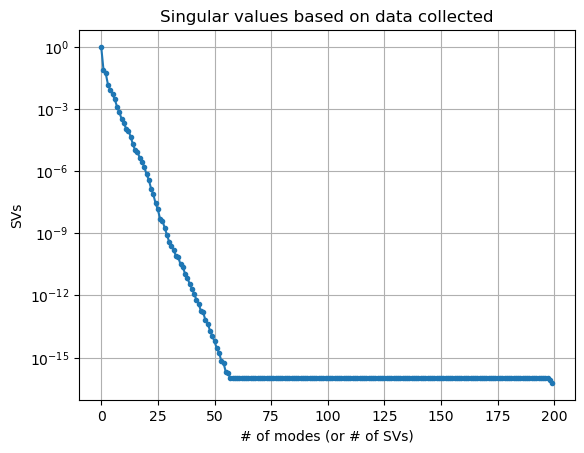

In [12]:
U, Sigma, Vh = svd(X, full_matrices=False)

print("Shapes:\n\tU {}\n\tSigma {}\n\tVh {}".format(np.shape(U),np.shape(Sigma),np.shape(Vh)))

plt.semilogy(Sigma/Sigma[0],'.-')
plt.title('Singular values based on data collected')
plt.xlabel('# of modes (or # of SVs)')
plt.ylabel('SVs')
plt.grid(True)
plt.show()

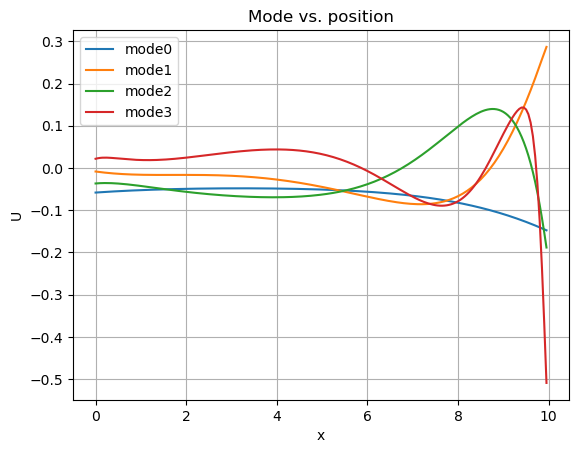

In [13]:
# plot a few modes of the left-singular vectors
plt.figure()
for r in range(0, 4):
    plt.plot(x[:-1],U[:,r],label='mode'+str(r))
plt.xlabel('x')
plt.ylabel('U')
plt.title('Mode vs. position')
plt.grid(True)
plt.legend()
plt.show()

# Perform Projection using POD-Galerkin

In [14]:
r = 4
print("at truncated rank={}, Sigma_r/Sigma_0 = {} is small".format(r,Sigma[r]/Sigma[0]))

at truncated rank=4, Sigma_r/Sigma_0 = 0.008406018261578267 is small


(1299,)
shape of the expansion coefficients: (4, 1299)


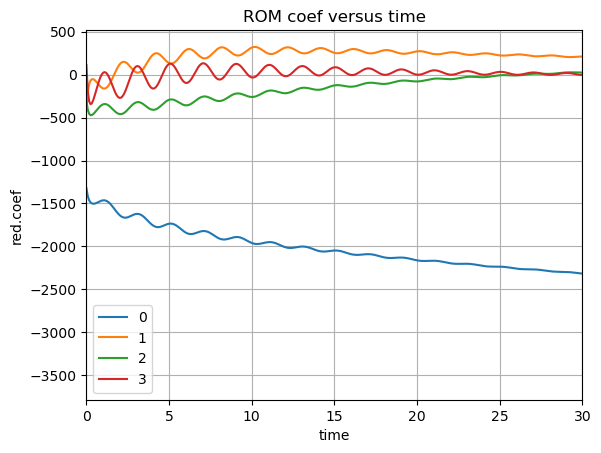

In [15]:
Ur = U[:, :r]
Ar = Ur.T @ A @ Ur
br = Ur.T @ b

# not really needed as it is the same function as FOM_function.
# only the A and b passed as arguments change, see call ot solve_ivp for args=(...)
def ROM_function(t,u,A,b):
    return -A@u + b * excitation(t)

# solve ODE
# note that initial condition is also projected !!
ROM = solve_ivp(ROM_function, [0, Tend], Ur.T @ Tinit, t_eval=t_events, args=(Ar,br), \
                rtol=rtol_, atol=atol_, method='Radau')
print(ROM.t.shape)
print("shape of the expansion coefficients:",ROM.y.shape)

plt.figure()
for ir in range(r):
    plt.plot(t_events,ROM.y[ir,:],label=str(ir))
plt.xlabel('time')
plt.ylabel('red.coef')
plt.title('ROM coef versus time')
plt.legend()
plt.grid(True)
plt.xlim([0,30])
plt.show()

# Reconstruct Approximate FOM States

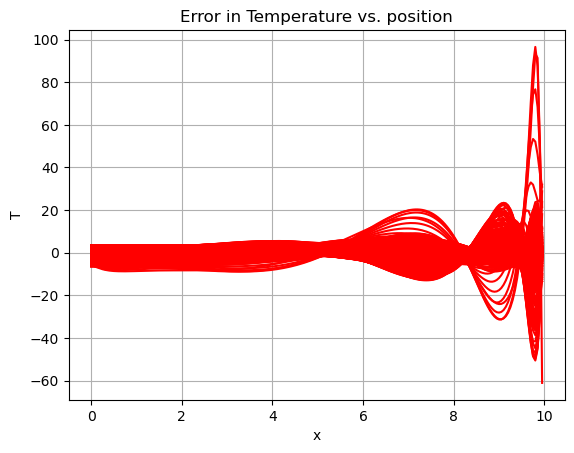

In [16]:
# Reconstructed States
reconst_FOM = Ur @ ROM.y

plt.figure()
for it,t in enumerate(FOM.t):
    if it%50:
        plt.plot(x[:-1],reconst_FOM[:,it]-FOM.y[:,it],'r')
plt.xlabel('x')
plt.ylabel('T')
plt.title('Error in Temperature vs. position')
plt.grid(True)
plt.show()

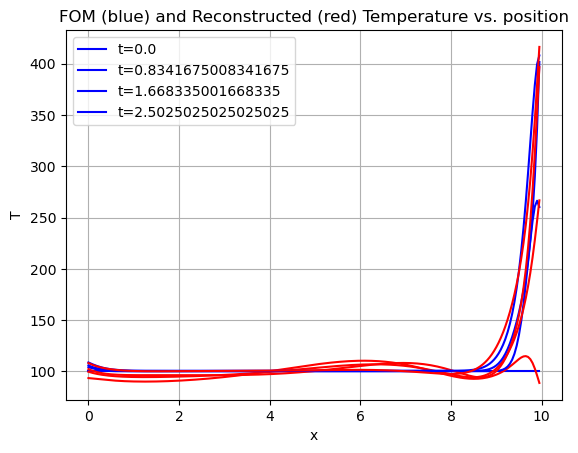

In [17]:
plt.figure()
itimes = np.arange(0,40,10)
for it in itimes:
    plt.plot(x[:-1],FOM.y[:,it],'b',label='t='+str(FOM.t[it]))
    plt.plot(x[:-1],reconst_FOM[:,it],'r')
plt.xlabel('x')
plt.ylabel('T')
plt.legend()
plt.title('FOM (blue) and Reconstructed (red) Temperature vs. position')
plt.grid(True)
plt.show()

measurements made at [194 198]


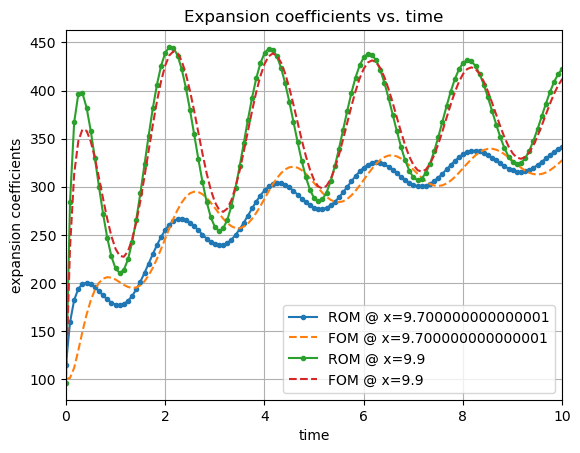

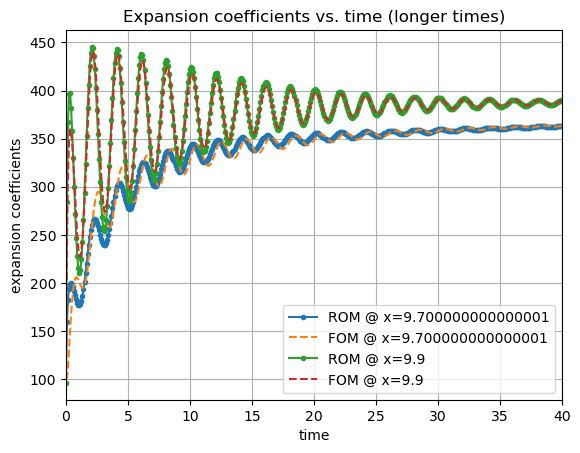

measurements made at [ 40  80 120 160]


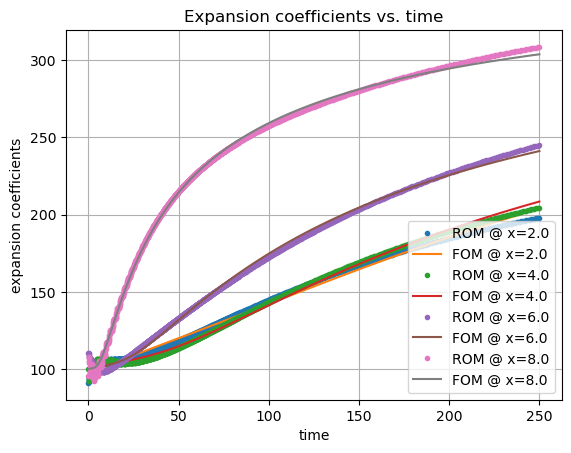

In [18]:
# pick a few points: the vertices at about 20%, 40%, 60%, and 80% of the solution vector
# these are like measurement points
pos=np.floor(len(x)*np.array([0.97,0.99])).astype(int)
print("measurements made at",pos)

plt.figure()
for p in pos:
    plt.plot(t_events,reconst_FOM[p,:],'.-',label='ROM @ x='+str(x[p]))
    plt.plot(t_events,FOM.y[p,:],'--',label='FOM @ x='+str(x[p]))
plt.xlabel('time')
plt.ylabel('expansion coefficients')
plt.legend()
plt.title('Expansion coefficients vs. time')
plt.grid(True)
plt.xlim([0,10])
plt.show()

plt.figure()
for p in pos:
    plt.plot(t_events,reconst_FOM[p,:],'.-',label='ROM @ x='+str(x[p]))
    plt.plot(t_events,FOM.y[p,:],'--',label='FOM @ x='+str(x[p]))
plt.xlabel('time')
plt.ylabel('expansion coefficients')
plt.legend()
plt.title('Expansion coefficients vs. time (longer times)')
plt.grid(True)
plt.xlim([0,40])
plt.show()

# other sets of measurement points
pos=np.floor(len(x)*np.array([0.2,0.4,0.6,0.8])).astype(int)
print("measurements made at",pos)

plt.figure()
for p in pos:
    plt.plot(t_events,reconst_FOM[p,:],'.',label='ROM @ x='+str(x[p]))
    plt.plot(t_events,FOM.y[p,:],'-',label='FOM @ x='+str(x[p]))
plt.xlabel('time')
plt.ylabel('expansion coefficients')
plt.legend()
plt.title('Expansion coefficients vs. time')
plt.grid(True)
# plt.xlim([0,40])
plt.show()

# Create state space control system

## caveat: 
We need to put $-A$ since I was building $Ax=b$ (like a steady state problem) which means that the system is
$$
\dot{x} = -A x + B u 
$$

In [19]:
#!pip install control
import control as ctrl

# list of positions of interest
pos=np.floor(len(x)*np.array([0.2,0.4,0.6,0.8, 0.97, 0.99])).astype(int)
print("We have a total of {} measurements of interest".format(len(pos)))

We have a total of 6 measurements of interest


system size =  200


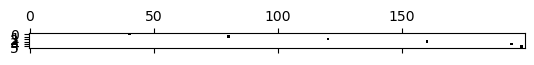

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Shape of A: (200, 200)
Shape of B: (200, 1)
Shape of C: (6, 200)
Shape of D: (6, 1)


In [20]:
print("system size = ",len(b))

# build C
C = np.zeros((len(pos),len(b)))
for i,p in enumerate(pos):
    C[i,p]=1
plt.figure()
plt.spy(C)
plt.show()

# build B
B = np.copy(b)
B = np.expand_dims(B,axis=1)

# build D
D = np.zeros((len(pos),1))
print(D)

print("Shape of A:",A.shape)
print("Shape of B:",B.shape)
print("Shape of C:",C.shape)
print("Shape of D:",D.shape)

# Generating state-space system
sys = ctrl.ss(-A,B,C,D)

# Simulate the LTI-System

In [21]:
t_events2 = np.linspace(0,Tend,2000)
T,yout,states = ctrl.forced_response(sys, T=t_events2, U=excitation(t_events2), X0=Tinit, return_x=True)

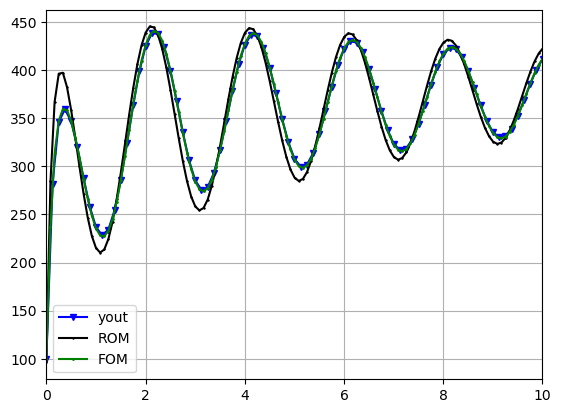

In [22]:
ip=-1
p=pos[ip]
plt.figure()

plt.plot(T,yout[ip,:],'b-v',ms=4, label='yout')
# plt.plot(T,states[p,:],'r.',ms=5, label='state')
plt.plot(t_events,reconst_FOM[p,:],'k+-',ms=2,label='ROM')
# plt.plot(t_events,C[ip,:]@FOM.y,'r.',ms=5, label='FOMv2')
plt.plot(t_events,FOM.y[p,:],'g-o',ms=1, label='FOM')

plt.grid(True)
plt.legend()
plt.xlim([0,10])
plt.show()

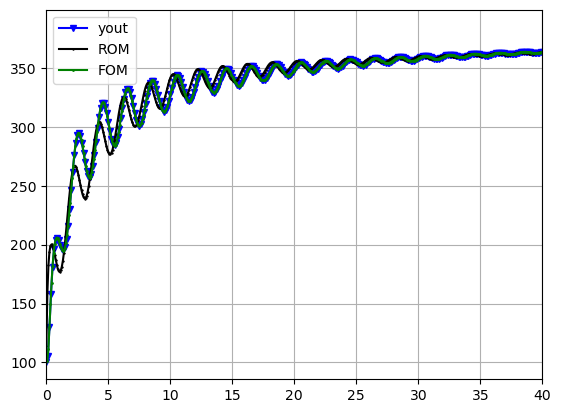

In [23]:
ip=-2
p=pos[ip]
plt.figure()

plt.plot(T,yout[ip,:],'b-v',ms=4, label='yout')
# plt.plot(T,states[p,:],'r.',ms=5, label='state')
plt.plot(t_events,reconst_FOM[p,:],'k+-',ms=2,label='ROM')
# plt.plot(t_events,C[ip,:]@FOM.y,'r.',ms=5, label='FOMv2')
plt.plot(t_events,FOM.y[p,:],'g-o',ms=1, label='FOM')

plt.grid(True)
plt.legend()
plt.xlim([0,40])
plt.show()

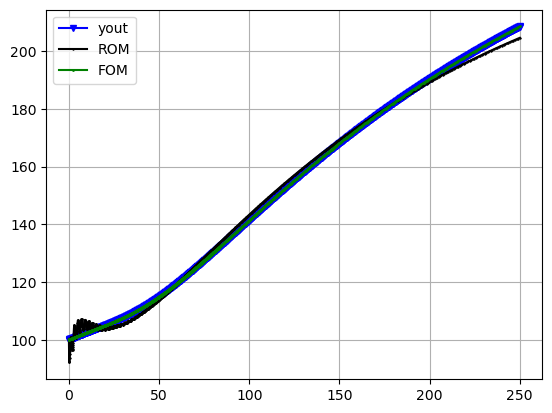

In [24]:
ip=1
p=pos[ip]
plt.figure()

plt.plot(T,yout[ip,:],'b-v',ms=4, label='yout')
# plt.plot(T,states[p,:],'r.',ms=5, label='state')
plt.plot(t_events,reconst_FOM[p,:],'k+-',ms=2,label='ROM')
# plt.plot(t_events,C[ip,:]@FOM.y,'r.',ms=5, label='FOMv2')
plt.plot(t_events,FOM.y[p,:],'g-o',ms=1, label='FOM')

plt.grid(True)
plt.legend()
# plt.xlim([0,40])
plt.show()

# Controllability / Observability
I had to install: conda install -c conda-forge slycot

In [25]:
import slycot
slycot.test()

# import control.matlab as ctrlmat
# from slycot import sb03md

================================================= test session starts =================================================
platform win32 -- Python 3.11.4, pytest-7.4.0, pluggy-1.0.0
rootdir: C:\Users\suparnob\OneDrive - Texas A&M University\TAMU_MATERIALS\ROM_COURSE\LECTURE NOTES\Others
plugins: anyio-3.7.1
collected 116 items

tests\test_ab01.py .                                                                                             [  0%]
tests\test_ab08n.py ..                                                                                           [  2%]
tests\test_ab13md.py .......                                                                                     [  8%]
tests\test_ag08bd.py ....                                                                                        [ 12%]
tests\test_analysis.py ...................                                                                       [ 28%]
tests\test_examples.py .............                                    

In [26]:
def is_mat_sym(mat):
    mat2=mat-mat.T
    if np.min(mat2)<1e-10 and np.max(mat2)<1e-10:
        print('symmetric')
    else:
        print('NOT symmetric')

symmetric
symmetric
NOT symmetric


LinAlgError: Matrix is not positive definite

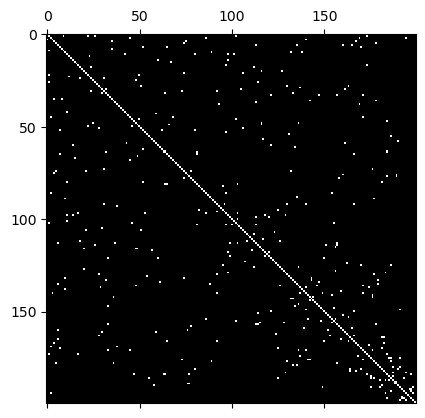

In [27]:
import scipy
mat = sys.B @ sys.B.T
# print(np.max(np.fabs(mat)))
# print(np.min(np.fabs(mat)))
is_mat_sym(mat)
is_mat_sym(sys.A)

P = ctrl.lyap(sys.A, mat, method='scipy')
is_mat_sym(P)
plt.figure()
plt.spy(P-P.T)
 
R = np.linalg.cholesky(P)

In [ ]:
Q = ctrl.lyap(sys.A, sys.C.T @ sys.C,method='scipy')
is_mat_sym(Q)

L = np.linalg.cholesky(Q)

### I wanted to do myself balance truncation and find the transformation T with the cholesky of P and Q but numpy claims the solutions of lyap() are not PD !!

# Balance truncation

In [ ]:
sys_red = ctrl.balred(sys,orders=4,method='truncate')

In [ ]:
print(sys_red)

In [ ]:
# solve the initial steady state for the reduced system
# caveat: I solve the steady-state problem, so I need to put a - in front of A that is in sys_red
Tinit_red = np.linalg.solve(-sys_red.A,sys_red.B)
print(Tinit_red)

In [ ]:
t_events2 = np.linspace(0,Tend,2000)
T,yout_red,states_red = ctrl.forced_response(sys_red, T=t_events2, U=excitation(t_events2), X0=Tinit_red, return_x=True)

In [ ]:
ip=-1
p=pos[ip]
plt.figure()

plt.plot(T,yout[ip,:],'b-v',ms=4, label='yout')
plt.plot(T,yout_red[ip,:],'m-v',ms=4, label='yout_red')
plt.plot(t_events,reconst_FOM[p,:],'k+-',ms=2,label='ROM')
plt.plot(t_events,FOM.y[p,:],'g-o',ms=1, label='FOM')

plt.grid(True)
plt.legend()
plt.xlim([0,10])
plt.show()

# Balance truncation using PYMOR

In [28]:
from pymor.models.iosys import LTIModel
from pymor.operators.numpy import NumpyMatrixOperator
from pymor.reductors.bt import BTReductor

In [29]:
fom = LTIModel.from_matrices(sys.A, sys.B, sys.C, sys.D)

In [30]:
# If you want to Compute Gramians (not needed)

Wc = fom.gramian('c_lrcf')  # Controllability Gramian
Wo = fom.gramian('o_lrcf')  # Observability Gramian

# Convert to NumPy arrays
Wc_ = Wc.to_numpy()
Wo_ = Wo.to_numpy()

In [31]:
r = 4  # desired reduced order
bt = BTReductor(fom)
rom = bt.reduce(r,projection='sr'); 

00:00 LTIPGReductor: Operator projection ...
00:00 LTIPGReductor: Building ROM ...


In [32]:
A_reduced = rom.A.matrix
B_reduced = rom.B.matrix
C_reduced = rom.C.matrix
D_reduced = rom.D.matrix

control_sys_reduced = ctrl.ss(A_reduced, B_reduced, C_reduced, D_reduced)

In [33]:
W=bt.W.to_numpy() # dim -> r,len(A)
V=bt.V.to_numpy() # dim -> r,len(A)

#Verify W and V are orthonormal
prod_WV = W@V.T 
print(prod_WV)

[[ 1.00000000e+00  5.55111512e-17  5.55111512e-17 -3.88578059e-16]
 [-4.99600361e-16  1.00000000e+00 -2.91433544e-16 -2.49800181e-16]
 [-1.05471187e-15 -4.71844785e-16  1.00000000e+00  5.27355937e-16]
 [-5.55111512e-17 -1.80411242e-16 -2.22044605e-16  1.00000000e+00]]


In [34]:
# Verify that A_reduced is formed using W and V

print(A_reduced)
print("--------")
print(-W@A@V.T)

[[-0.06541623 -0.3080459   0.16443595  0.06375946]
 [-0.4230012  -2.32238624  1.51197763  0.77932183]
 [ 0.39170893  2.60290652 -2.47018299 -1.77048842]
 [ 0.31629433  2.23107534 -2.4689717  -1.99834567]]
--------
[[-0.06541623 -0.3080459   0.16443595  0.06375946]
 [-0.4230012  -2.32238624  1.51197763  0.77932183]
 [ 0.39170893  2.60290652 -2.47018299 -1.77048842]
 [ 0.31629433  2.23107534 -2.4689717  -1.99834567]]


In [35]:
projected_initial_state = W@Tinit

In [36]:
t_events2 = np.linspace(0,Tend,2000)
T,yout_red,states_red = ctrl.forced_response(control_sys_reduced, T=t_events2, U=excitation(t_events2), X0=projected_initial_state, return_x=True)

In [37]:
reconst_FOM_BT = V.T@states_red
yout_red_reconstructed = C_reduced@W@reconst_FOM_BT

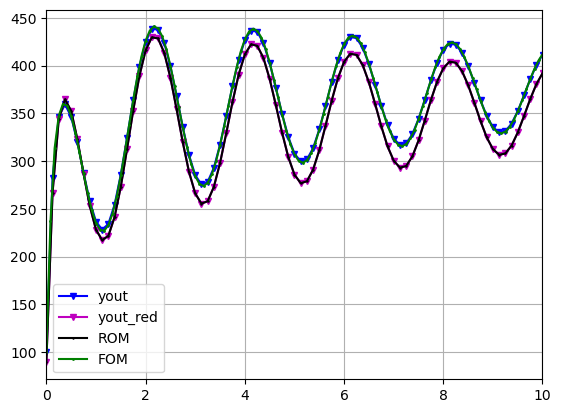

In [38]:
ip=-1
p=pos[ip]
plt.figure()

plt.plot(T,yout[ip,:],'b-v',ms=4, label='yout')
plt.plot(T,yout_red[ip,:],'m-v',ms=4, label='yout_red')
plt.plot(t_events2,reconst_FOM_BT[p,:],'k+-',ms=2,label='ROM')
plt.plot(t_events,FOM.y[p,:],'g-o',ms=1, label='FOM')

plt.grid(True)
plt.legend()
plt.xlim([0,10])
plt.show()